# Разведочный анализ данных (...)

- Автор: Чезганов Алексей
- Дата: 6.02.26

## Цели и задачи проекта

**Цель:**  
Провести исследовательский анализ рынка общественного питания Москвы и подготовить рекомендации для инвесторов.

**Основные задачи:**
- загрузить и объединить данные из нескольких источников;
- выполнить предобработку данных (типы, пропуски, дубликаты);
- провести исследовательский анализ:
  - распределения заведений по категориям и районам;
  - соотношение сетевых и несетевых заведений;
  - анализ посадочных мест, рейтингов и цен;
  - поиск факторов, влияющих на рейтинг заведений;
- сформулировать итоговые выводы и рекомендации для заказчика.

## Описание данных

Файл `/datasets/rest_info.csv` содержит информацию о заведениях общественного питания:

- `name` — название заведения;
- `address` — адрес заведения;
- `district` — административный район, в котором находится заведение, например Центральный административный округ;
- `category` — категория заведения, например «кафе», «пиццерия» или «кофейня»;
- `hours` — информация о днях и часах работы;
- `rating` — рейтинг заведения по оценкам пользователей в Яндекс Картах (высшая оценка — `5.0`);
- `chain` — число, выраженное `0` или `1`, которое показывает, является ли заведение сетевым (для маленьких сетей могут встречаться ошибки):
    - `0` — заведение не является сетевым;
    - `1` — заведение является сетевым.
- `seats` — количество посадочных мест.

Файл `/datasets/rest_price.csv` содержит информацию о среднем чеке в заведениях общественного питания:

- `price` — категория цен в заведении, например «средние», «ниже среднего», «выше среднего» и так далее;
- `avg_bill` — строка, которая хранит среднюю стоимость заказа в виде диапазона, например:
    - «Средний счёт: 1000–1500 ₽»;
    - «Цена чашки капучино: 130–220 ₽»;
    - «Цена бокала пива: 400–600 ₽».
        
        и так далее;
        
- `middle_avg_bill` — число с оценкой среднего чека, которое указано только для значений из столбца `avg_bill`, начинающихся с подстроки «Средний счёт»:
    - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    - Если значения нет или оно не начинается с подстроки «Средний счёт», то в столбец ничего не войдёт.
- `middle_coffee_cup` — число с оценкой одной чашки капучино, которое указано только для значений из столбца `avg_bill`, начинающихся с подстроки «Цена одной чашки капучино»:
    - Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    - Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    - Если значения нет или оно не начинается с подстроки «Цена одной чашки капучино», то в столбец ничего не войдёт.

## Содержимое проекта

(**Временно отсутствует**)

# Загрузка данных и знакомство с ними

Данный блок состоит из следующих этапов:
1. Импорт библиотек.
2. Загрузка датасетов.
3. Знакомство непосредственно с данными.

###  Импорт библиотек

In [1]:
# Загружаем библиотеки
import pandas as pd
import numpy as np

# Загружаем библиотеки для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем библиотеку для вычисления коэф. корреляции phi_k
from phik import phik_matrix

# Загружаем библиотеки для работы со строками
import re 
from difflib import SequenceMatcher # Сравнение двух последовательностей и поиск совпадающих фрагментов. (алгоритм Ратклиффа-Обершелпа)

### Загрузка датасетов

In [2]:
# Выгружаем данные в переменные rest_info и rest_price

rest_info = pd.read_csv('datasets/rest_info.csv')
rest_price = pd.read_csv('datasets/rest_price.csv')

### Знакомство с данными

Для ознакомления с данными в каждом датасете выведем общую информацию и первые 5 строк.

In [3]:
# Выводим первые 5 строк из датафрейма rest_info
rest_info.head()

,id,name,category,address,district,hours,rating,chain,seats
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",5.0,0,NaN
1,045780ada3474c57a2112e505d74b633,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",4.5,0,4.0
2,1070b6b59144425896c65889347fcff6,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",4.6,0,45.0
3,03ac7cd772104f65b58b349dc59f03ee,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",5.0,0,NaN
4,a163aada139c4c7f87b0b1c0b466a50f,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",5.0,1,148.0


In [4]:
# Выводим общую информацию о датафрейме rest_info
rest_info.info()

<class 'pandas.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        8406 non-null   str    
 1   name      8406 non-null   str    
 2   category  8406 non-null   str    
 3   address   8406 non-null   str    
 4   district  8406 non-null   str    
 5   hours     7870 non-null   str    
 6   rating    8406 non-null   float64
 7   chain     8406 non-null   int64  
 8   seats     4795 non-null   float64
dtypes: float64(2), int64(1), str(6)
memory usage: 591.2 KB


In [5]:
# Выведем минимальные и минимальные значения числовых признаков
rest_info[['seats', 'rating', 'chain']].agg(['max', 'min'])

,seats,rating,chain
max,1288.0,5.0,1
min,0.0,1.0,0


In [6]:
# Убедимся, что значения в поле chain принимают значения 0 или 1
rest_info['chain'].value_counts()

chain
0    5201
1    3205
Name: count, dtype: int64

**Промежуточный вывод:**

Датафрейм `reset_info` содержит 8406 записей. Данные представлены преимущественно строковым типом. В приведении к общему виду и переименованию полей нет необходимости. 

- Поле `chain` необоснованно имеет тип `int64`, так как, исходя из описания, данные в этом поле могут быть представлены `0` или `1` (Данные в датасете соответствуют описанию). 
- Поля `seats` и `rating` требуется привести к менее затратному по памяти целочисленному или вещественному типу. 
- Поле `hours` требуется разбить на категориальные и числовые признаки.

In [7]:
# Выводим первые 5 строк из датафрейма rest_price
rest_price.head()

,id,price,avg_bill,middle_avg_bill,middle_coffee_cup
0,045780ada3474c57a2112e505d74b633,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN
1,1070b6b59144425896c65889347fcff6,средние,Средний счёт:от 1000 ₽,1000.0,NaN
2,03ac7cd772104f65b58b349dc59f03ee,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0
3,a163aada139c4c7f87b0b1c0b466a50f,средние,Средний счёт:400–600 ₽,500.0,NaN
4,8a343546b24e4a499ad96eb7d0797a8a,средние,NaN,NaN,NaN


In [8]:
# Выводим общую информацию о датафрейме rest_price
rest_price.info()

<class 'pandas.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4058 non-null   str    
 1   price              3315 non-null   str    
 2   avg_bill           3816 non-null   str    
 3   middle_avg_bill    3149 non-null   float64
 4   middle_coffee_cup  535 non-null    float64
dtypes: float64(2), str(3)
memory usage: 158.6 KB


In [9]:
# Изучим диапазон числовых признаков
rest_price[['middle_avg_bill', 'middle_coffee_cup']].agg(['max', 'min'])

,middle_avg_bill,middle_coffee_cup
max,35000.0,1568.0
min,0.0,60.0


**Промежуточный вывод:** 

Датафрейм `rest_price` содержит 4057 записей, данные представлены строковыми и вещественными типами данных. Изменение типов не требуется. 

Поля `middle_avg_bill` и `middle_coffee_cup` необходимо сжать до `float16`. Проверка минимальных и максимальных значений демонстрирует эту возможность. 

Отдельно можно заметить, что размерность датафрейма `rest_price` в ~2 раза меньше, чем `rest_info`, следовательно при слиянии пропусков будет НЕМАЛО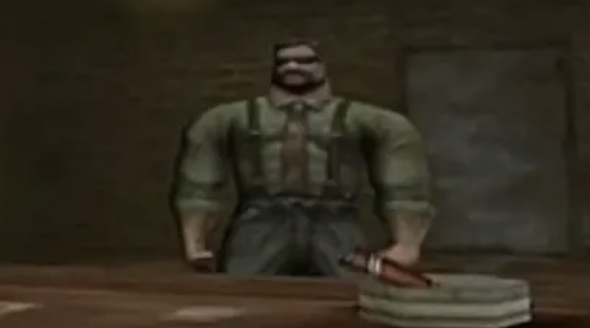

### Подготовка единого датасета

In [10]:
# Выполняем слияние датафреймов

df = pd.merge(rest_info, rest_price, how='left', on='id')

# Выведем первые 5 записей объединенного датафрейма
df.head()

,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",5.0,0,NaN,NaN,NaN,NaN,NaN
1,045780ada3474c57a2112e505d74b633,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",4.5,0,4.0,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN
2,1070b6b59144425896c65889347fcff6,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",4.6,0,45.0,средние,Средний счёт:от 1000 ₽,1000.0,NaN
3,03ac7cd772104f65b58b349dc59f03ee,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",5.0,0,NaN,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0
4,a163aada139c4c7f87b0b1c0b466a50f,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",5.0,1,148.0,средние,Средний счёт:400–600 ₽,500.0,NaN


In [11]:
# Выведем общую информацию об объединенном датафрейме 
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8406 non-null   str    
 1   name               8406 non-null   str    
 2   category           8406 non-null   str    
 3   address            8406 non-null   str    
 4   district           8406 non-null   str    
 5   hours              7870 non-null   str    
 6   rating             8406 non-null   float64
 7   chain              8406 non-null   int64  
 8   seats              4795 non-null   float64
 9   price              3315 non-null   str    
 10  avg_bill           3816 non-null   str    
 11  middle_avg_bill    3149 non-null   float64
 12  middle_coffee_cup  535 non-null    float64
dtypes: float64(4), int64(1), str(8)
memory usage: 853.9 KB


# Предобработка данных

Данный блок состоит из следующих этапов: 

1. Преобразование типов полей.
2. Обработка пропущенных значений.
3. Поиск и удаление явных и неявных дубликатов.
4. Разбиение полей `avg_bill` и `hours` на категориальные и числовые признаки.

## Преобразование типов полей

На этапе знакомства мы наметили следующие преобразования: 
- Поле `chain` необоснованно имеет тип `int64`, преобразуем в `bool`.
- Поля `seats` и `rating` требуется привести к `int16` (НО ЭТО НЕ ТОЧНО), в случае с `rating` предварительно сместив вещественую часть на порядок влево.
- Поля `middle_avg_bill` и `middle_coffee_cup` требуется сжать до `float16`.

In [12]:
# Выполним преобразование поля chain
df['chain'] = df['chain'].astype(bool)

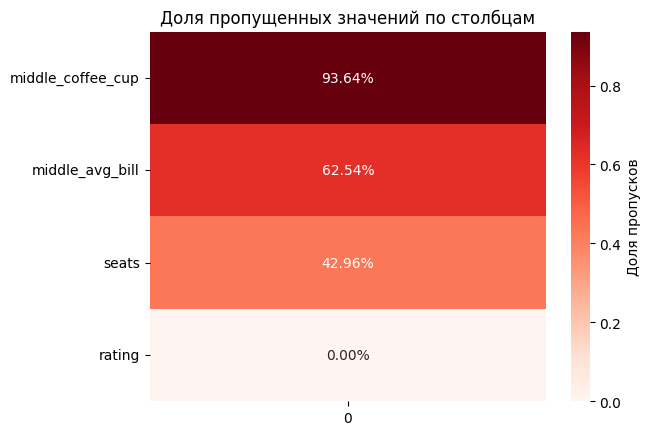

In [13]:
# Перед тем как продолжить преобразвание необходимо проверить наличие пропусков

# Считаем процент пропусков
missing_ratio = df[['rating', 'seats', 'middle_avg_bill', 'middle_coffee_cup']].isna().mean().sort_values(ascending=False)

# Создаем тепловую карту
sns.heatmap(missing_ratio.to_frame(),  # Преобразуем в нужный формат
            annot=True,
            fmt='.2%',
            cmap='Reds',
            cbar_kws={'label': 'Доля пропусков'},)

plt.title('Доля пропущенных значений по столбцам')
plt.show()

В поле `rating` пропусков не обнаружено, следовательно можно смело выполнять преобразование. 

У других полей обнаружено (НЕМАЛО) пропусков, от **42.96%** до **93.64%**, следовательно, их придется сохранить (пропуски), преобразовывать будем к `float16`. 

In [14]:
# Выполняем преобразование rating

# Выполним сдвиг десятичного разделителя
df['rating'] = df['rating'] * 10

# Непосредственное преобразование
df['rating'] = df['rating'].astype('int8')

In [15]:
# Выполняем преобразование seats, middle_avg_bill и middle_coffee_cup

change_cols = ['seats', 'middle_avg_bill', 'middle_coffee_cup']
df[change_cols] = df[change_cols].astype('float16')

In [16]:
# Выведем результат преобразований
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8406 non-null   str    
 1   name               8406 non-null   str    
 2   category           8406 non-null   str    
 3   address            8406 non-null   str    
 4   district           8406 non-null   str    
 5   hours              7870 non-null   str    
 6   rating             8406 non-null   int8   
 7   chain              8406 non-null   bool   
 8   seats              4795 non-null   float16
 9   price              3315 non-null   str    
 10  avg_bill           3816 non-null   str    
 11  middle_avg_bill    3149 non-null   float16
 12  middle_coffee_cup  535 non-null    float16
dtypes: bool(1), float16(3), int8(1), str(8)
memory usage: 591.2 KB


**Промежуточный вывод:** 

В результате оптимизации типов данных объем памяти, занимаемый датасетом, был сокращен с **853.9 KB** до **591.2 KB**. 

Ключевые преобразования:

1. Поле `chain` было преобразовано к типу `bool`. 
2. Поле `rating` было преобразовано к типу `int8`, также было совершен сдвиг десятичного разделителя, в следствии чего диапазон изменился: (**1.0-5.0**) --> (**10-50**)
3. Поля `seats`, `middle_avg_bill` и `middle_coffee_cup` были преобразованы к типу `float16`.

## Обработка пропущенных значений

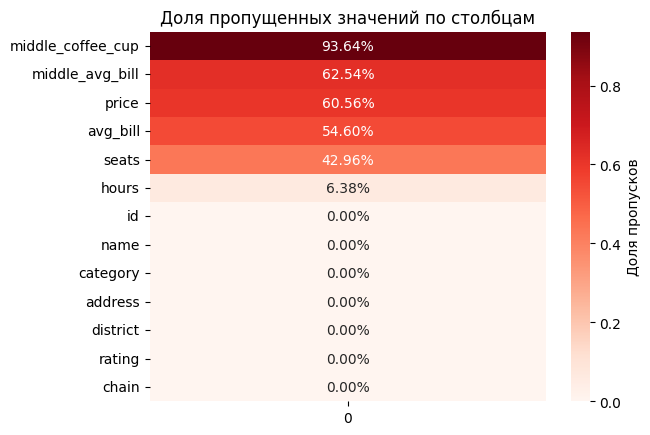

In [17]:
# Выведем информацию о пропусках во всех полях датасета

# Считаем процент пропусков
missing_ratio_all = df.isna().mean().sort_values(ascending=False)

# Создаем тепловую карту
sns.heatmap(missing_ratio_all.to_frame(),  # Преобразуем в нужный формат
            annot=True,
            fmt='.2%',
            cmap='Reds',
            cbar_kws={'label': 'Доля пропусков'},)

plt.title('Доля пропущенных значений по столбцам')
plt.show()

**Промежуточный вывод:** 

Ожидаемо большинство пропусков наблюдается с полях, изначально принадлежавших датафрейму `rest_price`. Это напрямую связано с разницей в количествах записей в изначальных датафреймах и методом сляния `left join`. 

Избавляться от этих пропусков нельзя, также как и от пропусков в поле `seats`. 

Однако их можно заменить, конкретнее: 

Для числовых полей `middle_avg_bill`, `middle_coffee_cup`, `seats` заменим пропуски на `-1`, так как данные, содержащиеся в этих полях, отрицательными быть не могут.

Строковые поля `price`, `avg_bill` заменим на `нет данных`.

Перед тем как продолжить, обратим внимание на данные, которые содержат пропуски во всех ключевых полях. А именно: `seats`, `hours`, `avg_bill` и `price`.


In [18]:
# Посчитаем количество записей с пропусками во всех ключевых полях
count_of_empty_lines = df[(df['hours'].isna()) 
                        & (df['seats'].isna()) 
                        & (df['avg_bill'].isna()) 
                        & (df['price'].isna())].shape[0]

# Выведем % таких записей
round(count_of_empty_lines * 100 / df.shape[0], 2)

2.8

Мы можем сделать вывод о том, что таких данных не много (менее 3%) и мы можем от них избавиться.

In [19]:
# Удаляем только те строки, где ВСЕ указанные столбцы содержат NaN
df = df.dropna(subset=['hours', 'seats', 'avg_bill', 'price'], how='all').reset_index(drop=True)

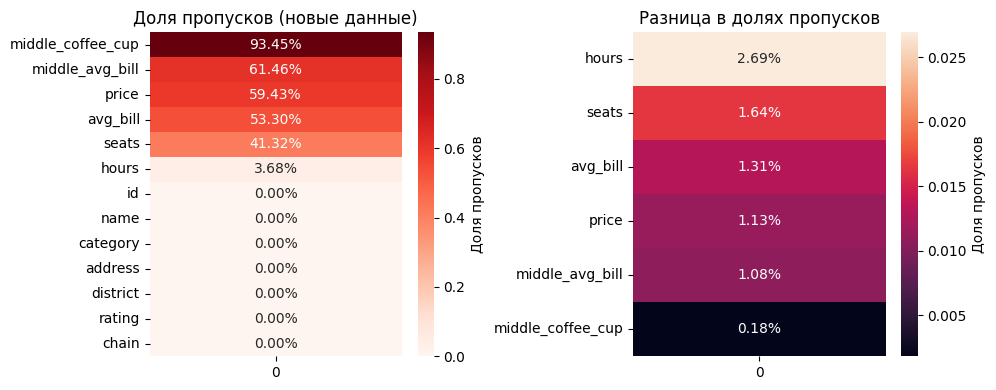

In [20]:
# Посмотрим как удаление отразидось на % пропусков в каждом поле

plt.figure(figsize=(10, 4))

# Обновим проценты пропусков 
missing_ratio_new = df.isna().mean().sort_values(ascending=False)

# Первый график (Результат) 
plt.subplot(1, 2, 1)
sns.heatmap(missing_ratio_new.to_frame(),
            annot=True,
            fmt='.2%',
            cmap='Reds',
            cbar_kws={'label': 'Доля пропусков'})
plt.title('Доля пропусков (новые данные)')

# Зафиксируем изменение
missing_ratio_diff = missing_ratio_all - missing_ratio_new
missing_ratio_diff = missing_ratio_diff[missing_ratio_diff != 0].sort_values(ascending=False)

# Второй график (Дельта)
plt.subplot(1, 2, 2)
sns.heatmap(missing_ratio_diff.to_frame(),
            annot=True,
            fmt='.2%',
            cbar_kws={'label': 'Доля пропусков'})
plt.title('Разница в долях пропусков')

plt.tight_layout()
plt.show()

Проведенная предварительная очистка данных оказала незначительное влияние на общее распределение пропусков. Это помогло принять решения об удалении строк с пропусками в поле `hours`. Исходная доля пропусков в этом поле составляла **6,38%**, что незначительно превышало допустимый порог в **5%** для автоматического удаления без дополнительного анализа.

In [21]:
# Удаляем строки содержащие пропуски в hours

df = df.dropna(subset=['hours']).reset_index(drop=True)
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7870 entries, 0 to 7869
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7870 non-null   str    
 1   name               7870 non-null   str    
 2   category           7870 non-null   str    
 3   address            7870 non-null   str    
 4   district           7870 non-null   str    
 5   hours              7870 non-null   str    
 6   rating             7870 non-null   int8   
 7   chain              7870 non-null   bool   
 8   seats              4495 non-null   float16
 9   price              3310 non-null   str    
 10  avg_bill           3808 non-null   str    
 11  middle_avg_bill    3143 non-null   float16
 12  middle_coffee_cup  534 non-null    float16
dtypes: bool(1), float16(3), int8(1), str(8)
memory usage: 553.5 KB


In [22]:
# Заполним пропуски в числовых полях
num_cols_to_fill = ['middle_avg_bill', 'middle_coffee_cup', 'seats']
df[num_cols_to_fill] = df[num_cols_to_fill].fillna(-1)

In [23]:
# Заполним пропуски в строковых полях
num_cols_to_fill = ['price', 'avg_bill']
df[num_cols_to_fill] = df[num_cols_to_fill].fillna('нет данных')

In [24]:
# Выведем общую информацию о получившемся датасете
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7870 entries, 0 to 7869
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7870 non-null   str    
 1   name               7870 non-null   str    
 2   category           7870 non-null   str    
 3   address            7870 non-null   str    
 4   district           7870 non-null   str    
 5   hours              7870 non-null   str    
 6   rating             7870 non-null   int8   
 7   chain              7870 non-null   bool   
 8   seats              7870 non-null   float16
 9   price              7870 non-null   str    
 10  avg_bill           7870 non-null   str    
 11  middle_avg_bill    7870 non-null   float16
 12  middle_coffee_cup  7870 non-null   float16
dtypes: bool(1), float16(3), int8(1), str(8)
memory usage: 553.5 KB


**Промежуточный вывод:**

В ходе обработки пропусков мы сократили размерность датасета на **6.38%**, что в общем приемлемо.
Теперь, в строковых полях вместо пропусков фигурирует значение `нет данных`, а в числовых `-1.0`. 

Есть предположение, что некоторые данные в поле `avg_bill`, содержащиеся в разных строках, могут принадлежать одному заведению, что в свою очередь поможет заполнить пропуски в вытекающих `middle_avg_bill` и `middle_coffee_cup` и сформировать новое поле `middle_beer_cup` отражающее стоимость бакала пива. Для проверки гиппотезы требуется нормализовать данные в полях и проверить на явные и неявные дубликаты.

In [25]:

combinations_count = df[['address', 'name']].value_counts() # Количества комбинаций адрес-название 
combinations_count.agg(['min', 'max'])

min    1
max    1
Name: count, dtype: int64

## Поиск и удаление явных и неявных дубликатов

Блок состоит из следующих этапов:
1. Нормализация значений
2. Поиск и удаление явных дубликатов
3. Поиск и удаление неявных дубликатов

### Нормализация значений

Нормализовывать мы будем значения в следующих полях: 

- `name`
- `address`
- `district`
- `hours`
- `category`
- `avg_bill`
- `price`

In [26]:
# Нормализуем значения
norm_cols = ['name', 'address', 'district', 'hours', 'category', 'avg_bill', 'price']
df[norm_cols] = df[norm_cols].apply(lambda col: col.str.lower().str.strip())

In [27]:
df.head()

/Users/achezganov/Documents/GitHub/msk_food_investment_research/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1466: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,id,name,category,address,district,hours,rating,chain,seats,price,avg_bill,middle_avg_bill,middle_coffee_cup
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,wowфли,кафе,"москва, улица дыбенко, 7/1",северный административный округ,"ежедневно, 10:00–22:00",50,False,-1.0,нет данных,нет данных,-1.0,-1.0
1,045780ada3474c57a2112e505d74b633,четыре комнаты,ресторан,"москва, улица дыбенко, 36, корп. 1",северный административный округ,"ежедневно, 10:00–22:00",45,False,4.0,выше среднего,средний счёт:1500–1600 ₽,1550.0,-1.0
2,1070b6b59144425896c65889347fcff6,хазри,кафе,"москва, клязьминская улица, 15",северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",46,False,45.0,средние,средний счёт:от 1000 ₽,1000.0,-1.0
3,03ac7cd772104f65b58b349dc59f03ee,dormouse coffee shop,кофейня,"москва, улица маршала федоренко, 12",северный административный округ,"ежедневно, 09:00–22:00",50,False,-1.0,нет данных,цена чашки капучино:155–185 ₽,-1.0,170.0
4,a163aada139c4c7f87b0b1c0b466a50f,иль марко,пиццерия,"москва, правобережная улица, 1б",северный административный округ,"ежедневно, 10:00–22:00",50,True,148.0,средние,средний счёт:400–600 ₽,500.0,-1.0


### Поиск и удаление явных дубликатов

Начнем с проверки категориальных признаков на ошибки: 

In [28]:
cat_cols = ['district', 'category', 'price', 'chain']

for col in cat_cols:
    print(df[col].value_counts(), '\n')

district
центральный административный округ         2211
северный административный округ             846
северо-восточный административный округ     830
южный административный округ                827
западный административный округ             785
восточный административный округ            723
юго-западный административный округ         650
юго-восточный административный округ        629
северо-западный административный округ      369
Name: count, dtype: int64 

category
кафе               2003
ресторан           1969
кофейня            1398
бар,паб             747
пиццерия            628
быстрое питание     570
столовая            306
булочная            249
Name: count, dtype: int64 

price
нет данных       4560
средние          2112
выше среднего     564
высокие           478
низкие            156
Name: count, dtype: int64 

chain
False    4781
True     3089
Name: count, dtype: int64 



**Промежуточный вывод:**

В категриальных полях не существенная вариативность значений, поэтому оценить их корректность можно визуально. В данных не обнаружено опечаток, синонимов и прочего, что могло бы искажать представление о категориях. 

In [29]:
df.duplicated().sum()

np.int64(0)

Заметим, полных дубликатов не найдено. Проверим на неявные: 

In [30]:
df['id'].duplicated().sum()

np.int64(0)

Неявных дубликатов также не обнаружено. 

## Добавление `middle_beer_cup` и разбиение `hours` на категориальные и числовые признаки.

### Извлечение информации о стоимости бокала пива (создание поля `middle_beer_cup`)

In [31]:
# Импортируем функцию парсинга для avg_bill
from parser import parse_middle_beer_cup

# Извлекаем информацию из avg_bill и заносим в новое поле middle_beer_cup
df['middle_beer_cup'] = df['avg_bill'].apply(parse_middle_beer_cup)

# Преобразуем поле к float16
df["middle_beer_cup"] = df["middle_beer_cup"].astype("float16")

In [32]:
# Выполним проверку
test = df[['avg_bill', 'middle_beer_cup']]
test.head()

/Users/achezganov/Documents/GitHub/msk_food_investment_research/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1466: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_bill,middle_beer_cup
0,нет данных,-1.0
1,средний счёт:1500–1600 ₽,-1.0
2,средний счёт:от 1000 ₽,-1.0
3,цена чашки капучино:155–185 ₽,-1.0
4,средний счёт:400–600 ₽,-1.0


In [33]:
test[test['middle_beer_cup'] != -1].head()

/Users/achezganov/Documents/GitHub/msk_food_investment_research/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1466: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_bill,middle_beer_cup
10,цена бокала пива:250–350 ₽,300.0
63,цена бокала пива:120–350 ₽,235.0
93,цена бокала пива:90–230 ₽,160.0
232,цена бокала пива:160–499 ₽,329.5
402,цена бокала пива:199–300 ₽,249.5


Данные обрабатываются корректно.

### Разбиение поля `hours`

Разбивать будем на следующие поля:

|Название|Тип|Описание|                                
|-----------|--------|---------------------------------------------------------------------|
|`is_24_7`  | `bool` | True: работает круглосуточно и ежедневно, False: в противном случае.|
|`is_night` | `bool` | True: работает ночью (попадает в интервал 22:00-6:00), False: в противном случае.|
|`is_day`   | `bool` | True: работает днем (попадает в интервал 6:00-22:00), False: в противном случае.|
|`on_week`  | `bool` | True: работают на неделе, False: в противном случае.|
|`on_weekend` | `bool` | True: работают на выходных, False: в противном случае.|
|`hours_on_week` | `float16` | (количество часов работы на неделе).|
|`hours_on_weekend` | `float16` | (количество часов работы в выходные)|


In [34]:
# Импортируем функцию обработки поял hours
from parser import hours_parser

# Новые поля
cols = [
    "is_24_7",
    "is_night",
    "is_day",
    "on_week",
    "on_weekend",
    "hours_on_week",
    "hours_on_weekend"
]

# добавляем новые
df[cols] = df["hours"].apply(hours_parser)

# Преобразуем поля к float16
df["hours_on_week"] = df["hours_on_week"].astype("float16")
df["hours_on_weekend"] = df["hours_on_weekend"].astype("float16")

# Преобразуем поля к типу bool 
bool_cols = ["is_24_7", "is_night", "is_day", "on_week", "on_weekend"]
df[bool_cols] = df[bool_cols].astype("bool")

In [35]:
# Выведем информацию из новых полей для проверки 
df[['hours', 'hours_on_week', 'hours_on_weekend'] + bool_cols]

/Users/achezganov/Documents/GitHub/msk_food_investment_research/venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1466: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,hours,hours_on_week,hours_on_weekend,is_24_7,is_night,is_day,on_week,on_weekend
0,"ежедневно, 10:00–22:00",60.0,24.0,False,False,True,True,True
1,"ежедневно, 10:00–22:00",60.0,24.0,False,False,True,True,True
2,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",78.0,33.0,False,True,True,True,True
3,"ежедневно, 09:00–22:00",65.0,26.0,False,False,True,True,True
4,"ежедневно, 10:00–22:00",60.0,24.0,False,False,True,True,True
...,...,...,...,...,...,...,...,...
7865,"ежедневно, 09:00–02:00",85.0,34.0,False,True,True,True,True
7866,"ежедневно, 08:00–22:00",70.0,28.0,False,False,True,True,True
7867,"ежедневно, круглосуточно",120.0,48.0,True,True,True,True,True
7868,"ежедневно, круглосуточно",120.0,48.0,True,True,True,True,True


Парсер отлично справился, все необходимые данные извлечены.